In [2]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [4]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [5]:
# Close any open database session.
# db.close()

# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [7]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [8]:
# Materials extracted.
execute("select count(*) from extracted_materials")

,count
0,23141


In [47]:
# Properties extracted.
execute("select count(*) from extracted_properties")

,count
0,52230


In [41]:
def extract_properties(property : str):
    df = execute("""
        SELECT pt.doi, em.entity_name AS material, ep.numeric_value, ep.unit
        FROM extracted_properties ep
        -- get material name and class
        JOIN extracted_materials em ON em.id = ep.material_id
        -- get doi
        JOIN paper_texts pt ON pt.id = em.para_id
        -- filter with property coreferents
        WHERE ep.entity_name IN (
            SELECT UNNEST(pm.other_names) FROM property_metadata pm
            WHERE pm.name = :prop_name
        )
        -- value should be within range
        AND ep.numeric_value >= (
            SELECT lower_limit FROM property_metadata
            WHERE name = :prop_name
        )
        AND ep.numeric_value <= (
            SELECT upper_limit FROM property_metadata
            WHERE name = :prop_name
        )
        -- select only polymers
        AND em.material_class LIKE 'POLYMER%';
    """, prop_name=property)
    return df

In [44]:
def plot_histogram(df, name, unit):
    df = extract_properties('bandgap')
    fig, ax = plt.subplots()
    df.hist('numeric_value', label='Total: %d' %df.shape[0], ax=ax)
    ax.legend()
    ax.set(xlabel=f'{name} ({unit})', ylabel='count',
           title=f'Extracted {name} data')
    plt.savefig(f'notebooks/hist.{name}.png', dpi=600)
    plt.show()

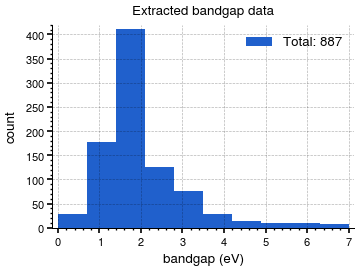

In [45]:
df = extract_properties('bandgap')
plot_histogram(df, 'bandgap', 'eV')

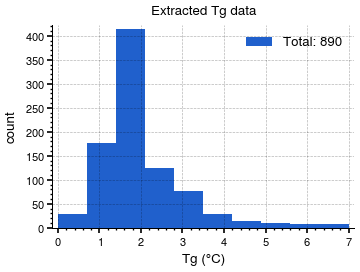

In [46]:
df = extract_properties('glass transition temperature')
plot_histogram(df, 'Tg', '°C')